# Lab session of 23/03/2022

## Graph problem 2: Minimum Spanning Tree, cutset formulation

Write and solve the cut-set formulation of the Minimum Spanning Tree (MST) for a random graph.

## Solution

A formulation of the MST problem uses *cut sets*: given a graph $G=(V,E)$ with $V$ the set of nodes and $E$ the set of edges, we create binary variables $x_{ij}$ for each $(i,j)\in E$ such that $x_{ij}$ is 1 if $(i,j)$ is in the solution, 0 otherwise. Then the formulation includes $cut set$ inequalities.

A *cut* $\delta(S)$ in a graph $G=(V,E)$ is a subset of edges generated by a subset of nodes $S\subset V$: an edge $(i,j)\in E$ is in $\delta(S)$ if exactly one among $i$ and $j$ is in $S$.


The formulation enforces the following condition:

__For any cut $\delta(S)$ containing the set of edges $(i,j)$ with $i$ in $S\subset V$ and $j$ in $V\setminus S$, there must be at least one edge of $\delta(S)$ in the solution.__

This implies that a formulation for the MST is 

$$
\begin{array}{lll}
  \min & \sum_{(i,j)\in E} c_{ij} x_{ij}\\
  \textrm{s.t.} & \sum_{(i,j)\in \mathcal \delta(S)} x_{ij} \ge 1 & \forall S\subset V:S\neq \emptyset\\
\end{array}
$$

Write the above formulation and solve it for a random graph.

In [1]:
# When using Colab, make sure you run this instruction beforehand
!pip install mip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 38.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import math

k = 11
grid_size = 100 # size of the grid of points

# distance beyond which we don't want edges
d_max = .75 * grid_size

np.random.seed(12345)

# Create k random points with two coordinates. Multiplying by grid_size yields
# random numbers between 0 and 100.
point = grid_size * np.random.random((k,2))

# Define the set of vertices of the graph as the list of numbers from 0 to k-1
V = [i for i in range(k)]

# Determine the distance between each point
distance = np.array([[math.sqrt(np.sum((point[i] - point[j])**2)) for i in V] for j in V])

# Set of edges: note the condition that i<j (so we have pairs i,j but not j,i)
# and especially the condition that prevents long arcs.
E = [(i,j) for i in V for j in V if i < j and distance[i,j] <= d_max]

Below is code for generating all subsets of a given list of objects. We will use `powerset` to create all constraints of the formulation.

In [3]:
from itertools import chain, combinations
powerset = list(chain.from_iterable(combinations(V, r) for r in V))

We have all we need to write the problem.

In [4]:
import mip

m = mip.Model()

x = {(i,j): m.add_var(var_type=mip.BINARY) for (i,j) in E}

for S in powerset:
    if len(S) > 0 and len(S) < k:
        m.add_constr(mip.xsum(x[i,j] for (i,j) in E
                              if (i in S and j not in S) or
                                 (j in S and i not in S))>= 1)
        
m.objective = mip.minimize(mip.xsum(distance[i,j]*x[i,j] for (i,j) in E))

m.optimize()

sol = [(i,j) for (i,j) in E if x[i,j].x > 0.5]
print(f"{len(sol)} edges in the solution: {sol}")

10 edges in the solution: [(0, 3), (1, 6), (1, 7), (2, 7), (2, 10), (3, 4), (3, 9), (4, 10), (5, 8), (8, 9)]


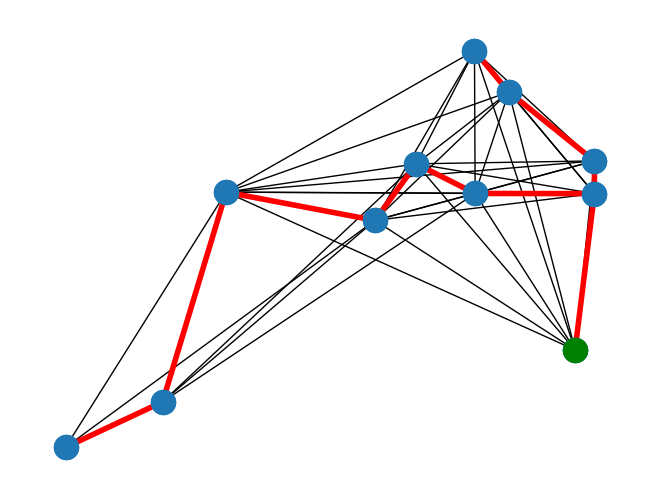

In [5]:
import networkx as nx

def draw_solution(V, A, x):
    g = nx.Graph()

    # Draw the whole graph first: all nodes, all arcs, no highlighting
    g.add_nodes_from(V)
    g.add_edges_from([(i,j) for (i,j) in A])
    nx.draw(g, pos=point)

    # Reset the graph and add only the arcs that belong to the solution, 
    # i.e. those for which the optimal value of the variable f[i,j] is nonzero
    g.clear()
    g.add_edges_from([(i,j) for (i,j) in A if x[i,j].x > 0.001])
    nx.draw(g, pos=point, width=4, edge_color='red')

    # finally, draw a graph consisting of the sole root node, highlighted in green
    g.clear()
    g.add_node(0)
    nx.draw(g, pos={0: point[0]}, node_color='green')
    
# after defining the function, call it with the current data
draw_solution (V, E, x)